In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy

from dataloaders import *
from util import Config
from viz_utils import *

In [63]:
datasets = ["MRPC", "TREC-2", "SUBJ", "AGN-2", "TREC-6", "AGN-4", "SST"]
dataset_map = {
    "TREC-2": "TREC-2",
    "SUBJ": "SUBJ",
    "AGN-2": "AGN-2",
    "TREC-6": "TREC-full",
    "SST": "SST",
    "COLA": "COLA",
    "AGN-4": "ag_news-full",
}
models = ["BERT", "ELECTRA"]
load_anti = False
n = 0  # AL step at which evaluation (AUC) starts
model = "BERT"
mode = "ada"
dataset = "TREC-6"

aucs = []
trs = []
try:
    experiments, meta = load_results(
        base_dir=f"results/unipelt/",
        dataset=dataset,
        model=model,
    )
except:
    print(f"No experiments for {dataset}-{model}-{mode}")
for load_mode in ["last", "best"]:
    if mode == "short" and load_mode == "best":
        continue
    mode_print = mode if load_mode == "last" else f"{mode}-besov"
    print(f"Loading {dataset} -- {mode_print} -- {model}")
    df_tr_i = results_to_df(experiments, mode=load_mode)

    df_tr_i["model"] = model
    df_tr_i["mode"] = mode_print
    df_tr_i["dataset"] = dataset
    df_tr_i = df_tr_i.reset_index().set_index(
        ["dataset", "model", "mode", "sampler", "experiment", "al_iter"]
    )
    trs.append(df_tr_i)

    df_auc_i = al_auc(df_tr_i)
    df_auc_i["mode"] = mode_print
    df_auc_i = df_auc_i.reset_index().set_index(["mode", "sampler"])
    aucs.append(df_auc_i)


# plot_besov_index(df_tr, ci=0)
# plot_al_accuracy(df_tr, metric="f1_micro", ci=0)
df_tr = pd.concat(trs)
df_auc = pd.concat(aucs)

TREC-6-BERT
Loading TREC-6 -- ada -- BERT
Loading TREC-6 -- ada-besov -- BERT


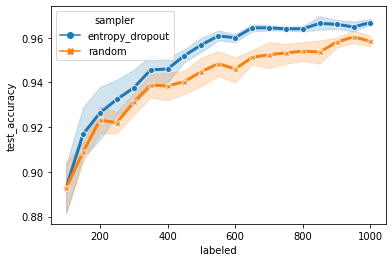

In [64]:
g = sns.lineplot(
    data=df_tr[df_tr.index.get_level_values("mode") == "ada-besov"],
    x="labeled",
    y="test_accuracy",
    hue="sampler",
    style="sampler",
    markers=True,
    dashes=False,
    ci=90,
    linewidth=3,
)
# plt.legend(loc='lower right')
# g.set_ylim(0.94, 0.985)
# g.set_xlim(150, 500)

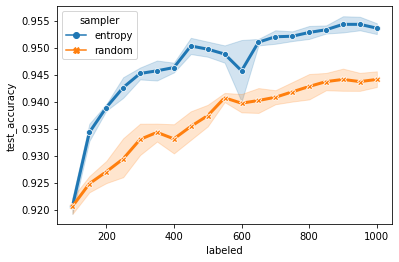

In [27]:
g = sns.lineplot(
    data=df_tr[df_tr.index.get_level_values("mode") == "ada-besov"],
    x="labeled",
    y="test_accuracy",
    hue="sampler",
    style="sampler",
    markers=True,
    dashes=False,
    ci=75,
    linewidth=3,
)
# plt.legend(loc='lower right')
# g.set_ylim(0.94, 0.985)
# g.set_xlim(150, 500)

In [22]:
df_tr.groupby(["dataset", "model", "model", "sampler", "experiment"]).agg(list)

labeled  \
dataset model model sampler experiment                                                      
SUBJ    BERT  BERT  entropy 0           [100, 150, 200, 250, 300, 350, 400, 450, 500, ...   
                            1           [100, 150, 200, 250, 300, 350, 400, 450, 500, ...   
                            2           [100, 150, 200, 250, 300, 350, 400, 450, 500, ...   
                            3           [100, 150, 200, 250, 300, 350, 400, 450, 500, ...   
                            4           [100, 150, 200, 250, 300, 350, 400, 450, 500, ...   
                    random  0           [100, 150, 200, 250, 300, 350, 400, 450, 500, ...   
                            1           [100, 150, 200, 250, 300, 350, 400, 450, 500, ...   
                            2           [100, 150, 200, 250, 300, 350, 400, 450, 500, ...   
                            3           [100, 150, 200, 250, 300, 350, 400, 450, 500, ...   
                            4           [100, 150, 200, 250, 300, 350, 400, 450, 500, ...   

                                                                               train_loss  \
dataset model model sampler experiment                                                      
SUBJ    BERT  BERT  entropy 0           [0.015600163460476324, 0.012404336314648389, 0...   
                            1           [0.0058130395409534685, 0.03375287461094558, 0...   
                            2           [0.004151124652707949, 0.02196246958337724, 0....   
                            3           [0.0025166915147565305, 0.020827480452135207, ...   
                            4           [0.0027115744160255417, 0.011673131631687284, ...   
                    random  0           [0.015600163460476324, 0.0035440850304439666, ...   
                            1           [0.0058130395409534685, 0.0011495442362502218,...   
                            2           [0.004151124652707949, 0.014242950198240577, 0...   
                            3           [0.0025166915147565305, 0.003502957301679999, ...   
                            4           [0.0027115744160255417, 0.0018485110718756913,...   

                                                                            test_accuracy  \
dataset model model sampler experiment                                                      
SUBJ    BERT  BERT  entropy 0           [0.9035, 0.915, 0.9135, 0.9345, 0.931, 0.934, ...   
                            1           [0.9195, 0.9295, 0.9365, 0.9385, 0.944, 0.942,...   
                            2           [0.916, 0.933, 0.936, 0.937, 0.9335, 0.943, 0....   
                            3           [0.911, 0.9355, 0.9355, 0.948, 0.943, 0.941, 0...   
                            4           [0.906, 0.9365, 0.9305, 0.936, 0.9465, 0.937, ...   
                    random  0           [0.9035, 0.892, 0.8925, 0.917, 0.9145, 0.9325,...   
                            1           [0.9195, 0.9125, 0.927, 0.937, 0.9235, 0.9375,...   
                            2           [0.916, 0.9275, 0.9145, 0.919, 0.933, 0.9295, ...   
                            3           [0.911, 0.92, 0.928, 0.9185, 0.9335, 0.9315, 0...   
                            4           [0.906, 0.9105, 0.911, 0.922, 0.9195, 0.925, 0...   

                                                                                 f1_micro  \
dataset model model sampler experiment                                                      
SUBJ    BERT  BERT  entropy 0           [0.9035, 0.915, 0.9135, 0.9345, 0.931, 0.934, ...   
                            1           [0.9195, 0.9295, 0.9365, 0.9385, 0.944, 0.942,...   
                            2           [0.916, 0.933, 0.936, 0.937, 0.9335, 0.943, 0....   
                            3           [0.911, 0.9355, 0.9355, 0.948, 0.943, 0.941, 0...   
                            4           [0.906, 0.9365, 0.9305, 0.936, 0.9465, 0.937, ...   
                    random  0           [0.9035, 0.892, 0.8925, 0.917, 0.9145, 0

In [ ]:
df_tr.groupby(["dataset", "model", "model", "sampler", "experiment"]).agg(list)
    

In [2]:
import os
import torch

import numpy as np
from podium import Vocab, Field, LabelField, Iterator  # , BucketIterator
from podium.datasets import TabularDataset
from podium.datasets.hf import HFDatasetConverter
from podium.vectorizers import GloVe
from podium.utils.general_utils import repr_type_and_attrs

from typing import Iterator as PythonIterator
from typing import NamedTuple, Tuple


from transformers import AutoTokenizer

from util import Config


class BucketIterator(Iterator):
    """
    Creates a bucket iterator which uses a look-ahead heuristic to batch
    examples in a way that minimizes the amount of necessary padding.

    Uses a bucket of size N x batch_size, and sorts instances within the bucket
    before splitting into batches, minimizing necessary padding.
    """

    def __init__(
        self,
        dataset=None,
        batch_size=32,
        sort_key=None,
        shuffle=True,
        seed=1,
        matrix_class=np.array,
        internal_random_state=None,
        look_ahead_multiplier=100,
        bucket_sort_key=None,
    ):
        """
        Creates a BucketIterator with the given bucket sort key and look-ahead
        multiplier (how many batch_sizes to look ahead when sorting examples for
        batches).

        Parameters
        ----------
        look_ahead_multiplier : int
            Multiplier of ``batch_size`` which determines the size of the
            look-ahead bucket.
            If ``look_ahead_multiplier == 1``, then the BucketIterator behaves
            like a normal Iterator.
            If ``look_ahead_multiplier >= (num_examples / batch_size)``, then
            the BucketIterator behaves like a normal iterator that sorts the
            whole dataset.
            Default is ``100``.
            The callable object used to sort examples in the bucket.
            If ``bucket_sort_key=None``, then the ``sort_key`` must not be ``None``,
            otherwise a ``ValueError`` is raised.
            Default is ``None``.

        Raises
        ------
        ValueError
            If sort_key and bucket_sort_key are both None.
        """

        if sort_key is None and bucket_sort_key is None:
            raise ValueError(
                "For BucketIterator to work, either sort_key or "
                "bucket_sort_key must be != None."
            )

        super().__init__(
            dataset,
            batch_size,
            sort_key=sort_key,
            shuffle=shuffle,
            seed=seed,
            matrix_class=matrix_class,
            internal_random_state=internal_random_state,
        )

        self.bucket_sort_key = bucket_sort_key
        self.look_ahead_multiplier = look_ahead_multiplier

    def __iter__(self) -> PythonIterator[Tuple[NamedTuple, NamedTuple]]:
        step = self.batch_size * self.look_ahead_multiplier
        dataset = self._dataset

        # Fix: Shuffle dataset if the shuffle is turned on, only IF sort key is not none
        if self._shuffle and self._sort_key is None:
            indices = list(range(len(dataset)))
            # Cache state prior to shuffle so we can use it when unpickling
            self._shuffler_state = self.get_internal_random_state()
            self._shuffler.shuffle(indices)
            # dataset.shuffle_examples(random_state=self._shuffler_state)
            dataset = dataset[indices]

        # Determine the step where iteration was stopped for lookahead & within bucket
        lookahead_start = (
            self.iterations // self.look_ahead_multiplier * self.look_ahead_multiplier
        )
        batch_start = self.iterations % self.look_ahead_multiplier

        if self._sort_key is not None:
            dataset = dataset.sorted(key=self._sort_key)
        for i in range(lookahead_start, len(dataset), step):
            bucket = dataset[i : i + step]

            if self.bucket_sort_key is not None:
                bucket = bucket.sorted(key=self.bucket_sort_key)

            for j in range(batch_start, len(bucket), self.batch_size):
                batch_dataset = bucket[j : j + self.batch_size]
                batch = self._create_batch(batch_dataset)

                yield batch
                self._iterations += 1

        # prepare for new epoch
        self._iterations = 0
        self._epoch += 1

    def __repr__(self) -> str:
        attrs = {
            "batch_size": self._batch_size,
            "epoch": self._epoch,
            "iteration": self._iterations,
            "shuffle": self._shuffle,
            "look_ahead_multiplier": self.look_ahead_multiplier,
        }
        return repr_type_and_attrs(self, attrs, with_newlines=True)


class TokenizerVocabWrapper:
    def __init__(self, tokenizer):
        # wrap BertTokenizer so the method signatures align with podium
        self.tokenizer = tokenizer

    def get_padding_index(self):
        return self.tokenizer.convert_tokens_to_ids(self.tokenizer.pad_token)

    def __len__(self):
        return len(self.tokenizer)

    def numericalize(self, instance):
        # Equivalent to .encode, but I want to delineate the steps
        return self.tokenizer.convert_tokens_to_ids(self.tokenizer.tokenize(instance))


def load_embeddings(vocab, name="glove"):
    if name == "glove":
        glove = GloVe()
        embeddings = glove.load_vocab(vocab)
        return embeddings
    else:
        raise ValueError(f"Wrong embedding key provided {name}")


def make_iterable(dataset, device, batch_size=32, train=False, indices=None):
    """
    Construct a DataLoader from a podium Dataset
    """

    def instance_length(instance):
        raw, tokenized = instance.text
        return -len(tokenized)

    def cast_to_device(data):
        return torch.tensor(np.array(data), device=device)

    # Selects examples at given indices to support subset iteration.
    if indices is not None:
        dataset = dataset[indices]

    # iterator = BucketIterator(
    #     dataset,
    #     batch_size=batch_size,
    #     sort_key=instance_length,
    #     shuffle=train,
    #     matrix_class=cast_to_device,
    #     look_ahead_multiplier=20,
    # )

    iterator = Iterator(
        dataset,
        batch_size=batch_size,
        shuffle=train,
        matrix_class=cast_to_device,
    )

    return iterator


class Instance:
    def __init__(self, index, text, label, extras=None):
        self.index = index
        self.text = text
        self.label = label
        self.extras = extras
        self.length = len(text)  # text is already tokenized & filtered

    def set_mask(self, masked_text, masked_labels):
        # Set the masking as an attribute
        self.masked_text = masked_text
        self.masked_labels = masked_labels

    def set_numericalized(self, indices, target):
        self.numericalized_text = indices
        self.numericalized_label = target
        self.length = len(indices)

    def __repr__(self):
        return f"{self.index}: {self.length}, {self.label}"


def generate_eraser_rationale_mask(tokens, evidences):
    mask = torch.zeros(len(tokens))  # zeros for where you can attend to

    any_evidence_left = False
    for ev in evidences:
        if ev.start_token > len(tokens) or ev.end_token > len(tokens):
            continue  # evidence out of span

        if not any_evidence_left:
            any_evidence_left = True
        # 1. Validate

        assert ev.text == " ".join(
            tokens[ev.start_token : ev.end_token]
        ), "Texts dont match; did you filter some tokens?"

        mask[ev.start_token : ev.end_token] = 1
    return mask


def load_tse(
    train_path="data/TSE/train.csv", test_path="data/TSE/test.csv", max_size=20000
):

    vocab = Vocab(max_size=max_size)
    fields = [
        Field("id", numericalizer=None),
        Field("text", numericalizer=vocab, include_lengths=True),
        Field("rationale", numericalizer=vocab),
        LabelField("label"),
    ]
    train_dataset = TabularDataset(
        train_path, format="csv", fields=fields, skip_header=True
    )
    test_dataset = TabularDataset(
        test_path, format="csv", fields=fields, skip_header=True
    )
    train_dataset.finalize_fields()
    return (train_dataset, test_dataset), vocab


class MaxLenHook:
    def __init__(self, max_len):
        self.max_len = max_len

    def __call__(self, raw, tokenized):
        return raw, tokenized[: self.max_len]


def lowercase_hook(raw, tokenized):
    return raw, [tok.lower() for tok in tokenized]


def isalnum(token):
    return any(c.isalnum() for c in token)


def remove_nonalnum(raw, tokenized):
    # Remove non alphanumeric tokens
    return raw, [tok for tok in tokenized if isalnum(tok)]


def load_imdb(
    meta,
    tokenizer=None,
    max_vocab_size=20_000,
    max_seq_len=200,
):

    return load_dataset(
        "data/IMDB",
        meta=meta,
        tokenizer=tokenizer,
        max_vocab_size=max_vocab_size,
        max_seq_len=max_seq_len,
    )


def load_isear(
    meta,
    tokenizer=None,
    max_vocab_size=20_000,
    max_seq_len=200,
):

    return load_dataset(
        "data/ISEAR",
        meta=meta,
        tokenizer=tokenizer,
        max_vocab_size=max_vocab_size,
        max_seq_len=max_seq_len,
    )


def load_agn2(
    meta,
    tokenizer=None,
    max_vocab_size=20_000,
    max_seq_len=200,
):

    return load_dataset(
        "data/AGN-2",
        meta=meta,
        tokenizer=tokenizer,
        max_vocab_size=max_vocab_size,
        max_seq_len=max_seq_len,
    )


def load_agn4(
    meta,
    tokenizer=None,
    max_vocab_size=20_000,
    max_seq_len=200,
):

    return load_dataset(
        "data/AGN-4",
        meta=meta,
        tokenizer=tokenizer,
        max_vocab_size=max_vocab_size,
        max_seq_len=max_seq_len,
    )


def load_mnli(
    meta,
    tokenizer=None,
    max_vocab_size=20_000,
    max_seq_len=200,
):
    return load_sequence_pair_dataset(
        "data/GLUE/MNLI",
        meta=meta,
        tokenizer=tokenizer,
        max_vocab_size=max_vocab_size,
        max_seq_len=max_seq_len,
    )


def load_mrpc(
    meta,
    tokenizer=None,
    max_vocab_size=20_000,
    max_seq_len=200,
):
    return load_sequence_pair_dataset(
        "data/GLUE/MRPC",
        meta=meta,
        tokenizer=tokenizer,
        max_vocab_size=max_vocab_size,
        max_seq_len=max_seq_len,
    )


def load_qqp(
    meta,
    tokenizer=None,
    max_vocab_size=20_000,
    max_seq_len=200,
):
    return load_sequence_pair_dataset(
        "data/GLUE/QQP",
        meta=meta,
        tokenizer=tokenizer,
        max_vocab_size=max_vocab_size,
        max_seq_len=max_seq_len,
    )


def test_load_cola(meta, tok):
    splits, vocab = load_cola(meta, tok)
    print(vocab)
    train, valid, test = splits
    print(len(train), len(valid), len(test))

    print(train)
    print(train[0])

    device = torch.device("cpu")
    train_iter = make_iterable(test, device, batch_size=2)
    batch = next(iter(train_iter))

    print(batch)
    text, length = batch.text
    print(length[0])
    print(vocab.get_padding_index())


def load_sequence_pair_dataset(
    data_dir, meta, tokenizer=None, max_vocab_size=20_000, max_seq_len=200
):

    # Use BERT subword tokenization
    vocab = TokenizerVocabWrapper(tokenizer)
    print(vocab.get_padding_index())
    pad_index = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
    fields = [
        Field("id", disable_batch_matrix=True),
        Field(
            "sequence1",
            tokenizer=tokenizer.tokenize,
            padding_token=pad_index,
            numericalizer=tokenizer.convert_tokens_to_ids,
            include_lengths=True,
            posttokenize_hooks=[
                remove_nonalnum,
                MaxLenHook(max_seq_len),
                lowercase_hook,
            ],
        ),
        Field(
            "sequence2",
            tokenizer=tokenizer.tokenize,
            padding_token=pad_index,
            numericalizer=tokenizer.convert_tokens_to_ids,
            include_lengths=True,
            posttokenize_hooks=[
                remove_nonalnum,
                MaxLenHook(max_seq_len),
                lowercase_hook,
            ],
        ),
        LabelField("label"),
    ]

    train = TabularDataset(
        os.path.join(data_dir, "train.csv"), format="csv", fields=fields
    )
    val = TabularDataset(
        os.path.join(data_dir, "validation.csv"), format="csv", fields=fields
    )
    test = TabularDataset(
        os.path.join(data_dir, "test.csv"), format="csv", fields=fields
    )

    train.finalize_fields()

    meta.vocab = vocab
    meta.num_tokens = len(vocab)
    meta.padding_idx = vocab.get_padding_index()
    meta.num_labels = len(train.field("label").vocab)

    return (train, val, test), vocab


def load_dataset(
    data_dir, meta, tokenizer=None, max_vocab_size=20_000, max_seq_len=200
):

    # Use BERT subword tokenization
    vocab = TokenizerVocabWrapper(tokenizer)
    pad_index = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
    fields = [
        Field("id", disable_batch_matrix=True),
        Field(
            "text",
            tokenizer=tokenizer.tokenize,
            padding_token=pad_index,
            numericalizer=tokenizer.convert_tokens_to_ids,
            include_lengths=True,
            posttokenize_hooks=[
                remove_nonalnum,
                MaxLenHook(max_seq_len),
                lowercase_hook,
            ],
        ),
#         LabelField("label"),
    ]

    train = TabularDataset(
        os.path.join(data_dir, "train.csv"), format="csv", fields=fields
    )
    val = TabularDataset(
        os.path.join(data_dir, "validation.csv"), format="csv", fields=fields
    )
    test = TabularDataset(
        os.path.join(data_dir, "test.csv"), format="csv", fields=fields
    )

    train.finalize_fields()

    meta.vocab = vocab
    meta.num_tokens = len(vocab)
    meta.padding_idx = vocab.get_padding_index()
    meta.num_labels = len(train.field("label").vocab)

    return (train, val, test), vocab


def load_sst(
    meta,
    tokenizer=None,
    max_vocab_size=20_000,
    max_seq_len=200,
):
    return load_dataset(
        "data/GLUE/SST-2",
        meta=meta,
        tokenizer=tokenizer,
        max_vocab_size=max_vocab_size,
        max_seq_len=max_seq_len,
    )


def test_load_sst(max_vocab_size=20_000, max_seq_len=200):
    splits, vocab = load_sst()
    print(vocab)
    train, valid, test = splits
    print(len(train), len(valid), len(test))

    print(train)
    print(train[0])

    device = torch.device("cpu")
    train_iter = make_iterable(train, device, batch_size=2)
    batch = next(iter(train_iter))

    print(batch)
    text, length = batch.text
    print(vocab.reverse_numericalize(text[0]))
    print(length[0])
    print(vocab.get_padding_index())


def load_trec2(
    meta,
    tokenizer=None,
    max_vocab_size=20_000,
    max_seq_len=200,
):

    return load_dataset(
        "data/TREC-2",
        meta=meta,
        tokenizer=tokenizer,
        max_vocab_size=max_vocab_size,
        max_seq_len=max_seq_len,
    )


def load_trec6(
    meta,
    tokenizer=None,
    max_vocab_size=20_000,
    max_seq_len=200,
):

    return load_dataset(
        "data/TREC-6",
        meta=meta,
        tokenizer=tokenizer,
        max_vocab_size=max_vocab_size,
        max_seq_len=max_seq_len,
    )


def load_cola(
    meta,
    tokenizer=None,
    max_vocab_size=20_000,
    max_seq_len=200,
):

    return load_dataset(
        "data/GLUE/COLA",
        meta=meta,
        tokenizer=tokenizer,
        max_vocab_size=max_vocab_size,
        max_seq_len=max_seq_len,
    )


def load_polarity(
    meta,
    tokenizer=None,
    max_vocab_size=20_000,
    max_seq_len=200,
):

    return load_dataset(
        "data/POL",
        meta=meta,
        tokenizer=tokenizer,
        max_vocab_size=max_vocab_size,
        max_seq_len=max_seq_len,
    )


def load_subj(
    meta,
    tokenizer=None,
    max_vocab_size=20_000,
    max_seq_len=200,
):

    return load_dataset(
        "data/SUBJ",
        meta=meta,
        tokenizer=tokenizer,
        max_vocab_size=max_vocab_size,
        max_seq_len=max_seq_len,
    )


def load_trec_hf(label="label-coarse", max_vocab_size=20_000, max_seq_len=200):
    vocab = Vocab(max_size=max_vocab_size)
    fields = [
        Field(
            "text",
            numericalizer=vocab,
            include_lengths=True,
            posttokenize_hooks=[MaxLenHook(max_seq_len)],
            keep_raw=True,
        ),
        LabelField("label"),
    ]
    hf_dataset = load_dataset("trec")
    hf_dataset = hf_dataset.rename_column(label, "label")
    print(hf_dataset)
    hf_train_val, hf_test = (
        hf_dataset["train"],
        hf_dataset["test"],
    )
    train_val_conv = HFDatasetConverter(hf_train_val, fields=fields)
    test_conv = HFDatasetConverter(hf_test, fields=fields)
    train_val, test = (
        train_val_conv.as_dataset(),
        test_conv.as_dataset(),
    )
    train, val = train_val.split(split_ratio=0.8, random_state=0)
    train.finalize_fields()
    print(train)
    return (train, val, test), vocab


def add_ids_to_files(root_folder):
    split_ins = ["train_old.csv", "dev_old.csv", "test_old.csv"]
    split_outs = ["train.csv", "dev.csv", "test.csv"]

    for split_in, split_out in zip(split_ins, split_outs):
        with open(os.path.join(root_folder, split_in), "r") as infile:
            with open(os.path.join(root_folder, split_out), "w") as outfile:
                for idx, line in enumerate(infile):
                    parts = line.strip().split(",")
                    if idx == 0:
                        continue
                    outfile.write(f"{idx-1},{parts[0]},{parts[1]}\n")


In [40]:
from models import *
from args import *
from dataloaders import *

args = Config()
args.lr = 1e-4
args.l2 = 0
args.model = "BERT"
args.data = "TREC-6"
args.adapter = "adapters/TREC-6-BERT-UNIPELT"
args.batch_size = 32
args.epochs = 50
args.clip = 1

meta = Config()

dataloader = dataset_loaders[args.data]
tokenizer = AutoTokenizer.from_pretrained(TRANSFORMERS[args.model])
(train, val, test), vocab = dataloader(meta=meta, tokenizer=tokenizer)

if args.data in pair_sequence_datasets:
    meta.pair_sequence = True
else:
    meta.pair_sequence = False

if meta.num_labels == 2:
    # Binary classification
    criterion = nn.BCEWithLogitsLoss()
    meta.num_targets = 1
else:
    # Multiclass classification
    criterion = nn.CrossEntropyLoss()
    meta.num_targets = meta.num_labels
    
model = Transformer(args, meta, args.model, pretrained="adapter", adapter=args.adapter)
optimizer = torch.optim.AdamW(model.parameters(), lr=args.lr, weight_decay=args.l2)
device = torch.device("cuda:0")



model.to(device)
train_iter = make_iterable(
    train,
    device,
    batch_size=args.batch_size,
    train=True,
#     indices=indices,
)

OSError: Unable to load adapter adapters/TREC-6-BERT-adapters/TREC-6-BERT-UNIPELT from any source. Please check the name of the adapter or the source.

In [11]:
import time
from al.experiment import Experiment


def train_model(model, optimizer, criterion, train_iter):
    model.train()

    total_loss = 0.0
    accuracy, confusion_matrix = 0, np.zeros(
        (meta.num_labels, meta.num_labels), dtype=int
    )

    logit_list = []
    y_true_list = []
    ids = []
    for batch_num, batch in enumerate(train_iter, 1):
        t = time.time()

        optimizer.zero_grad()

        ids.extend([int(id[0]) for id in batch.id])

        # Unpack batch & cast to device
        if meta.pair_sequence:
            (x_sequence1, sequence1_lengths) = batch.sequence1
            (x_sequence2, sequence2_lengths) = batch.sequence2
        else:
            (x, lengths) = batch.text

        y = batch.label
        y_true_list.append(y.squeeze(0) if y.numel() == 1 else y.squeeze())

        if meta.pair_sequence:
            # PSQ
            lengths = (sequence1_lengths, sequence2_lengths)
            logits, return_dict = model(x_sequence1, x_sequence2, lengths)
        else:
            # SSQ
            logits, return_dict = model(x, lengths)
        logit_list.append(logits)

        # Bookkeeping and cast label to float
        accuracy, confusion_matrix = Experiment.update_stats(
            accuracy, confusion_matrix, logits, y
        )
        if logits.shape[-1] == 1:
            # binary cross entropy, cast labels to float
            y = y.type(torch.float)

        loss = criterion(logits.view(-1, meta.num_targets).squeeze(), y.squeeze())

        total_loss += float(loss)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), args.clip)
        optimizer.step()

        print(
            "[Batch]: {}/{} in {:.5f} seconds".format(
                batch_num, len(train_iter), time.time() - t
            ),
            end="\r",
            flush=True,
        )

    loss = total_loss / len(train_iter)
    result_dict = {"loss": loss}
    logit_tensor = torch.cat(logit_list)
    y_true = torch.cat(y_true_list)
    return result_dict, logit_tensor, y_true, ids

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [41]:
train_results = []
for epoch in range(1, args.epochs + 1):
    print(f"Training epoch: {epoch}/{args.epochs}")
    # a) Train for one epoch
    result_dict_train, logits, y_true, ids = train_model(
        model, optimizer, criterion, train_iter
    )
    print(result_dict_train)
    train_results.append(result_dict_train)

    # b) Evaluate model (test set)
#     eval_result_dict = self._evaluate_model(model)
#     acc.append(eval_result_dict["accuracy"])
#     loss.append(result_dict_train["loss"])
#     eval_results.append(eval_result_dict)

Training epoch: 1/50
{'loss': 0.01814777716174376}onds
Training epoch: 2/50
{'loss': 0.013025298618572378}nds
Training epoch: 3/50
{'loss': 0.01351945994633752}onds
Training epoch: 4/50
{'loss': 0.014833319083891183}nds
Training epoch: 5/50
{'loss': 0.0288949630460138}conds
Training epoch: 6/50
{'loss': 0.01359997551116976}onds
Training epoch: 7/50
{'loss': 0.008445000201732}econds
Training epoch: 8/50
{'loss': 0.003933654185175328}nds
Training epoch: 9/50
{'loss': 0.00489842581157518}onds
Training epoch: 10/50
{'loss': 0.011394525419973434}nds
Training epoch: 11/50
{'loss': 0.01280247760439579}onds
Training epoch: 12/50
{'loss': 0.011529065110607917}nds
Training epoch: 13/50
{'loss': 0.005138173452110095}nds
Training epoch: 14/50
{'loss': 0.011042796112178621}nds
Training epoch: 15/50
{'loss': 0.0020343127159776486}ds
Training epoch: 16/50
{'loss': 0.016601067070837416}nds
Training epoch: 17/50
{'loss': 0.007180607903194414}nds
Training epoch: 18/50
{'loss': 0.005696840342238829}nds
T

In [13]:
model.eval()
name = model.get_classifier_name()
clf = model.classifier #getattr(model.classifier, name)
config = model.classifier.config
num_layers = config.num_hidden_layers

print(num_layers)

12


In [14]:
df = df_tr[
    (df_tr.index.get_level_values("sampler") == "entropy")
    & (df_tr.index.get_level_values("mode") == "ada-besov")
    & (df_tr.index.get_level_values("experiment") == 0)
]

In [15]:
selected = df.selected.agg(list)

In [16]:
sel = [s for ss in selected for s in ss]

In [17]:
indices = np.array(sel)

In [42]:
enc = []
grads = []
labels = []
enc_layers = {i: [] for i in range(num_layers)}


train_iter = make_iterable(
    train,
    device,
    batch_size=args.batch_size,
    train=False,
    indices=indices,
)


with torch.inference_mode():
    for batch in train_iter:

        print(batch)
        inputs, _ = batch.text
        labels.append(batch.label)
        inputs.requires_grad = False

    #     embedded_tokens = clf.bert.embeddings(inputs)
    #     embedded_tokens = torch.autograd.Variable(
    #         embedded_tokens, requires_grad=True
    #     )
        encoded_all = clf(
            inputs,
            output_hidden_states=True,
            # head_mask=head_mask,
            # attention_mask=attention_mask,
        )
        # Skip the embedding layer [1:]
        for i, enc_layer in enumerate(encoded_all[1][1:]):
            enc_layers[i].append(enc_layer[:, 0].cpu())


        encoded = encoded_all[0][:, 0]
        enc.append(encoded.cpu())

        torch.cuda.empty_cache()

    y = torch.cat(labels)
    for k, v in enc_layers.items():
        X = torch.cat(v)
        enc_layers[k] = X

Batch({
    id: [['4442'], ['3232'], ['1394'], ['3291'], ['2935'], ['1759'], ['2570'], ['1266'], ['947'], ['3735'], ['3879'], ['1554'], ['1940'], ['2422'], ['3757'], ['442'], ['3294'], ['5008'], ['2737'], ['614'], ['4142'], ['1143'], ['563'], ['4516'], ['4478'], ['726'], ['1453'], ['3919'], ['3888'], ['1416'], ['216'], ['3616']],
    text: (tensor([[ 2040,  6791,  2492,  8610, 22209, 17083, 10199,  1999,  1996,  5532,
              4419,     0,     0,     0,     0,     0,     0,     0,     0],
            [ 2073,  2064,  2017,  2424,  1996, 11691,  4875,  6494,  2361,     0,
                 0,     0,     0,     0,     0,     0,     0,     0,     0],
            [ 2054,  2515,  2169,  1997,  1996, 16548,  3465,  1999, 15404,     0,
                 0,     0,     0,     0,     0,     0,     0,     0,     0],
            [ 2339,  2003,  1996,  2773, 22498,  2061,  2146,     0,     0,     0,
                 0,     0,     0,     0,     0,     0,     0,     0,     0],
            [ 2054,  

Batch({
    id: [['3051'], ['3809'], ['3295'], ['4906'], ['4578'], ['2957'], ['3708'], ['2362'], ['3009'], ['1186'], ['3687'], ['3639'], ['1752'], ['1395'], ['276'], ['5135'], ['2047'], ['1139'], ['3271'], ['4215'], ['5298'], ['4105'], ['2686'], ['1553'], ['4132'], ['4339'], ['1941'], ['61'], ['4439'], ['3359'], ['4920'], ['3664']],
    text: (tensor([[ 2129,  2079,  2017,  5466,  1037,  2160,  9028,  6562,  2283,     0,
                 0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
                 0],
            [ 2054,  4708,  2515,  1996,  8945,  2226, 14356,  8843,  1997,  3899,
              4685,     0,     0,     0,     0,     0,     0,     0,     0,     0,
                 0],
            [ 1999,  2054,  2095,  2001,  1996,  4068,  2813,  7019,     0,     0,
                 0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
                 0],
            [ 2054,  2024,  1996,  6666,  1997,  1037, 12037,  3698,     0,     0,
              

Batch({
    id: [['3609'], ['4314'], ['4591'], ['4666'], ['3662'], ['879'], ['3761'], ['1877'], ['1357'], ['1370'], ['361'], ['2754'], ['3905'], ['2633'], ['4943'], ['668'], ['3386'], ['1415'], ['4552'], ['253'], ['2710'], ['2581'], ['3167'], ['1487'], ['4085'], ['1534'], ['1445'], ['236'], ['1410'], ['943'], ['1707'], ['3917']],
    text: (tensor([[ 2054,  2515,  2345,  2176,  6523,  2000,  1999,  1996,  2998,  2088,
                 0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
                 0],
            [ 2043,  2170,  2588,  2000,  7806,  2054,  2137,  2236,  3880,  2909,
              1045,  2031,  2025,  2664,  5625,  2000,  2954,     0,     0,     0,
                 0],
            [ 2054,  1055,  1996, 12652,  1997,  1996,  2879, 10158,     0,     0,
                 0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
                 0],
            [ 2054,  2024,  1996,  2350,  3316,  2008,  2024,  2112,  1997, 23268,
              355

Batch({
    id: [['2888'], ['4334'], ['5373'], ['1862'], ['3021'], ['2356'], ['3624'], ['2798'], ['2947'], ['4506'], ['3845'], ['707'], ['3423'], ['4261'], ['702'], ['1334'], ['1798'], ['92'], ['2410'], ['2766'], ['3033'], ['4124'], ['2663'], ['4299'], ['226'], ['2425'], ['1652'], ['258'], ['3721'], ['3548'], ['2875'], ['1761']],
    text: (tensor([[ 2054,  2785,  1997,  2111,  2165,  2112,  1999, 18789,  2015,  7417,
              1999,  4404,  1999, 16057,     0,     0,     0,     0,     0,     0,
                 0,     0,     0],
            [ 2054,  2024,  1996,  3415,  1997,  2035,  1996, 11915,  1999,  1996,
              2088,  1998,  2054,  4153,  2079,  2027, 12475,  2046,     0,     0,
                 0,     0,     0],
            [ 2054,  2616,  1999,  1996,  2394,  2031,  2048,  1057,  1055,  2067,
              2000,  2067,     0,     0,     0,     0,     0,     0,     0,     0,
                 0,     0,     0],
            [ 2054,  7967,  2194,  3957,  2017,  1037,  20

Batch({
    id: [['5015'], ['1031'], ['5382'], ['4535'], ['588'], ['1101'], ['1002'], ['5329'], ['3041'], ['2695'], ['5218'], ['4140'], ['5150'], ['2161'], ['2945'], ['5292'], ['4891'], ['5179'], ['4648'], ['1831'], ['5377'], ['1945'], ['4759'], ['1424'], ['532'], ['1100'], ['3744'], ['4456'], ['5236'], ['2639'], ['4606'], ['5357']],
    text: (tensor([[ 2171,  1996,  2176, 25431,  1997,  1996, 16976,     0,     0,     0,
                 0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
                 0],
            [ 2054,  2003, 13541,  9335,  2154,     0,     0,     0,     0,     0,
                 0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
                 0],
            [ 2054,  2112,  2106,  6425,  5951,  2377,  1999,  1996,  2458,  1997,
              1996,  3780,  1999,  2637,     0,     0,     0,     0,     0,     0,
                 0],
            [ 2054,  2177,  2001,  2719,  1999,  3440,  2044,  2610,  2777,  5012,
             

Batch({
    id: [['4768'], ['1168'], ['1213'], ['305'], ['3841'], ['3387'], ['4285'], ['2660'], ['3278'], ['3401'], ['4199'], ['335'], ['2608'], ['4928'], ['3460'], ['3197'], ['3874'], ['2645'], ['1003'], ['2652'], ['5004'], ['545'], ['1983'], ['1625'], ['2551'], ['1614'], ['4728'], ['2508'], ['5375'], ['2498'], ['3830'], ['3539']],
    text: (tensor([[ 2054,  2204,  2024, 22529,  2229,     0,     0,     0,     0,     0,
                 0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
                 0,     0],
            [ 2054,  3042,  2193,  2064,  1045,  2655,  2000,  2031,  1037,  3392,
              8461,     0,     0,     0,     0,     0,     0,     0,     0,     0,
                 0,     0],
            [ 2054,  2106,  1996,  3806,  2160,  6080,  2377,     0,     0,     0,
                 0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
                 0,     0],
            [ 2054,  2024,  1996,  1021,  4790,  1997,  1996,  4552,     0, 

Batch({
    id: [['2677'], ['3083'], ['3012'], ['692'], ['2826'], ['5195'], ['3734'], ['2515'], ['4258'], ['3330'], ['4079'], ['4323'], ['338'], ['2139'], ['574'], ['3482'], ['845'], ['4971'], ['3384'], ['4699'], ['2874'], ['652'], ['1769'], ['3901'], ['2728'], ['1348'], ['3866'], ['5073'], ['1046'], ['2894'], ['1029'], ['4585']],
    text: (tensor([[ 2054,  2003,  1996,  2440,  5579,  1997,  1037,  3203, 11829,     0,
                 0,     0,     0,     0,     0,     0,     0,     0,     0],
            [ 2054,  2020,  8670, 15379, 10424, 16429,  4509,  2121,  1998,  5951,
              2559,  2005,     0,     0,     0,     0,     0,     0,     0],
            [ 2054,  5072,  1999,  2417,  4511,  2003,  2204,  2005,  1996,  2540,
              1998,  2054,  3599,  2515,  2009,  2079,  2000,  2115,  2303],
            [ 2054,  2515,  1037,  9152, 19466,  2923,  2903,  1999,     0,     0,
                 0,     0,     0,     0,     0,     0,     0,     0,     0],
            [ 2054, 

Batch({
    id: [['1468'], ['1721'], ['1961'], ['5314'], ['807'], ['2063'], ['4153'], ['2065'], ['5132'], ['4611'], ['3362'], ['2980'], ['747'], ['3350'], ['4318'], ['3812'], ['3800'], ['4120'], ['5062'], ['3038'], ['1908'], ['2255'], ['968'], ['5257'], ['3327'], ['4586'], ['4584'], ['705'], ['5200'], ['3352'], ['3326'], ['3211']],
    text: (tensor([[ 2029,  2557,  3703,  2250,  1996,  3958,  8945,  4819,  8540,  2557,
              2831,  2265,     0,     0,     0,     0,     0,     0,     0,     0],
            [ 5900,  2003,  9919,  2054,     0,     0,     0,     0,     0,     0,
                 0,     0,     0,     0,     0,     0,     0,     0,     0,     0],
            [ 2054,  2024,  1996,  5640, 16371, 28990,  2015,  2013,  1015,  2000,
              2184,     0,     0,     0,     0,     0,     0,     0,     0,     0],
            [ 2054,  7187,  4862, 17519,  2001,  2577, 18031,  1996,  2034,  6778,
              1997,     0,     0,     0,     0,     0,     0,     0,     0,

Batch({
    id: [['4675'], ['2788'], ['4690'], ['798'], ['4815'], ['4821'], ['607'], ['5128'], ['542'], ['476'], ['5039'], ['5052'], ['5103'], ['381'], ['4292'], ['5253'], ['4338'], ['4497'], ['5395'], ['1250'], ['2466'], ['4916'], ['519'], ['1557'], ['1550'], ['1892'], ['3921'], ['2548'], ['2640'], ['4342'], ['969'], ['3141']],
    text: (tensor([[ 2054,  2003,  1996,  4633,  2066,  2006,  1996,  4231,     0,     0,
                 0,     0,     0,     0,     0,     0,     0,     0,     0],
            [ 2054,  2515,  1996, 13445,  2832,  4372, 14162,     0,     0,     0,
                 0,     0,     0,     0,     0,     0,     0,     0,     0],
            [ 2054,  2003,  1996,  2087,  2691,  2879,  1055,  2030,  2611,  1055,
              2171,     0,     0,     0,     0,     0,     0,     0,     0],
            [ 2054,  2828,  1997,  5933,  2024, 12850,  2869,  2109,  2005,     0,
                 0,     0,     0,     0,     0,     0,     0,     0,     0],
            [ 2054,  2

Batch({
    id: [['4188'], ['1720'], ['584'], ['4325'], ['2122'], ['28'], ['5046'], ['2476'], ['2069'], ['4150'], ['4049'], ['2583'], ['3794'], ['1995'], ['4047'], ['4027'], ['2902'], ['5060'], ['1644'], ['2700'], ['2785'], ['4865'], ['3081'], ['299'], ['4953'], ['283'], ['1870'], ['3443'], ['174'], ['1740'], ['602'], ['466']],
    text: (tensor([[ 2054,  7433,  9560,  3463,  2043,  1037,  2447,  2038,  2053,  3423,
              2693,     0,     0,     0,     0,     0,     0],
            [ 2054,  2003,  1996,  2976,  6263, 11897,     0,     0,     0,     0,
                 0,     0,     0,     0,     0,     0,     0],
            [ 2054,  2001,  1996,  2171,  1997,  2008,  2759,  2299,  1996, 19815,
              2015,  6369,     0,     0,     0,     0,     0],
            [ 2054,  2003,  1996,  2959,  9812,     0,     0,     0,     0,     0,
                 0,     0,     0,     0,     0,     0,     0],
            [ 2054,  2003,  1996,  2028,  2518,  2017,  2342,  2077,  2017,  20

Batch({
    id: [['5115'], ['2081'], ['1962'], ['2316'], ['89'], ['2323'], ['2328'], ['168'], ['171'], ['249'], ['4780'], ['3303'], ['1153'], ['2509'], ['853'], ['2423'], ['4379'], ['1209'], ['3354'], ['3'], ['3787'], ['2455'], ['3971'], ['4309'], ['5277'], ['1397'], ['3729'], ['4386'], ['2090'], ['5125'], ['3770'], ['1254']],
    text: (tensor([[ 2054,  2515, 28776, 21877, 15714, 11090,  2368,  2298,  2066,     0,
                 0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
                 0,     0,     0,     0,     0,     0],
            [ 1999,  2054,  2095,  2106,  1996,  2149,  3884,  3650, 11092,  1996,
             12652,  7367,  8737,  2121, 26000,  6856,     0,     0,     0,     0,
                 0,     0,     0,     0,     0,     0],
            [ 2054,  2515,  1996, 14460,  2468,  1999,  1996,  3010,  3179,  1997,
             15404,     0,     0,     0,     0,     0,     0,     0,     0,     0,
                 0,     0,     0,     0,     0,     0]

In [70]:
X = enc_layers[11]

In [28]:
enc = []
grads = []
labels = []
enc_layers = {i: [] for i in range(num_layers)}


train_iter = make_iterable(
    train,
    device,
    batch_size=args.batch_size,
    train=False,
    indices=indices,
)

for batch in train_iter:

    print(batch)
    inputs, _ = batch.text
    labels.append(batch.label)
    inputs.requires_grad = False

    embedded_tokens = clf.embeddings(inputs)
    embedded_tokens = torch.autograd.Variable(
        embedded_tokens, requires_grad=True
    )
    encoded_all = clf(
        embedded_tokens,
        output_hidden_states=True,
        # head_mask=head_mask,
        # attention_mask=attention_mask,
    )
    # Skip the embedding layer [1:]
    for i, enc_layer in enumerate(encoded_all[1][1:]):
        enc_layers[i].append(enc_layer[:, 0].cpu())

    encoded = encoded_all[0][:, 0]
    enc.append(encoded.cpu())

    mean = encoded.mean()
    mean.backward()
    enc_grad = embedded_tokens.grad.data
    grads.append(enc_grad.norm(p=2, dim=(1, 2)))

    torch.cuda.empty_cache()

y = torch.cat(labels)
for k, v in enc_layers.items():
    X = torch.cat(v)
    enc_layers[k] = X

Batch({
    id: [['4442'], ['3232'], ['1394'], ['3291'], ['2935'], ['1759'], ['2570'], ['1266'], ['947'], ['3735'], ['3879'], ['1554'], ['1940'], ['2422'], ['3757'], ['442'], ['3294'], ['5008'], ['2737'], ['614'], ['4142'], ['1143'], ['563'], ['4516'], ['4478'], ['726'], ['1453'], ['3919'], ['3888'], ['1416'], ['216'], ['3616']],
    text: (tensor([[ 2040,  6791,  2492,  8610, 22209, 17083, 10199,  1999,  1996,  5532,
              4419,     0,     0,     0,     0,     0,     0,     0,     0],
            [ 2073,  2064,  2017,  2424,  1996, 11691,  4875,  6494,  2361,     0,
                 0,     0,     0,     0,     0,     0,     0,     0,     0],
            [ 2054,  2515,  2169,  1997,  1996, 16548,  3465,  1999, 15404,     0,
                 0,     0,     0,     0,     0,     0,     0,     0,     0],
            [ 2339,  2003,  1996,  2773, 22498,  2061,  2146,     0,     0,     0,
                 0,     0,     0,     0,     0,     0,     0,     0,     0],
            [ 2054,  

AttributeError: 'BertAdapterModel' object has no attribute 'embeddings'

In [30]:
enc_layers

{0: [],
 1: [],
 2: [],
 3: [],
 4: [],
 5: [],
 6: [],
 7: [],
 8: [],
 9: [],
 10: [],
 11: []}

In [48]:
clf.encoder.forward?

In [ ]:
X_model = enc_layers[-1].detach().numpy()

In [ ]:
from cka import *

n = 12

lin_vals = np.empty((n, n))
rbf_vals = np.empty((n, n))
    
for i in range(12):
    enc1 = enc_layers[i].detach().cpu().numpy()
    for j in range(i, 12):
        enc2 = enc_layers[j].detach().cpu().numpy()
        lin = linear_CKA(enc1, enc2)
        rbf = kernel_CKA(enc1, enc2)
        lin_vals[i, j] = lin_vals[j, i] = lin
        rbf_vals[i, j] = rbf_vals[j, i] = rbf

In [86]:
from cka import *

n = 18

lin_vals = np.empty((n, n))
rbf_vals = np.empty((n, n))
for i in range(100, 1000, 50):
    A = X[i:i+50]
    print(f"Sample {i//50 - 1}")
    for j in range(i, 1000, 50):
        B = X[j:j+50]
        lin = linear_CKA(A, B)
        rbf = kernel_CKA(A, B)
        i_mod = i // 50 - 2
        j_mod = j // 50 - 2
        lin_vals[i_mod, j_mod] = lin_vals[j_mod, i_mod] = lin
        rbf_vals[i_mod, j_mod] = rbf_vals[j_mod, i_mod] = rbf

Sample 1
Sample 2
Sample 3
Sample 4
Sample 5
Sample 6
Sample 7
Sample 8
Sample 9
Sample 10
Sample 11
Sample 12
Sample 13
Sample 14
Sample 15
Sample 16
Sample 17
Sample 18


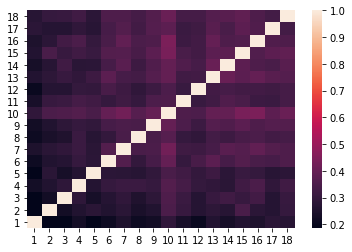

In [90]:
sns.heatmap(np.flip(rbf_vals, 1), xticklabels=range(1, 18+1), yticklabels=range(18, 0, -1));

In [121]:
print(lin_vals)

[[1.         0.98248242 0.96114412 0.95121319 0.90460212 0.71041576
  0.47315452 0.38221755 0.31722107 0.27903575 0.25892686 0.24506719]
 [0.98248242 1.         0.99294096 0.98335407 0.95183908 0.75358897
  0.50744447 0.41371993 0.34471121 0.30324662 0.28150918 0.26641857]
 [0.96114412 0.99294096 1.         0.99445655 0.96767089 0.76605118
  0.51650029 0.42217762 0.3524165  0.31063183 0.28872567 0.27348558]
 [0.95121319 0.98335407 0.99445655 1.         0.97601547 0.78270474
  0.53881083 0.44590866 0.37730722 0.33579883 0.31386207 0.29857912]
 [0.90460212 0.95183908 0.96767089 0.97601547 1.         0.86372819
  0.64402416 0.55500195 0.48563069 0.44082381 0.41642609 0.39986809]
 [0.71041576 0.75358897 0.76605118 0.78270474 0.86372819 1.
  0.91641715 0.85514805 0.80074403 0.7619774  0.73903904 0.72382307]
 [0.47315452 0.50744447 0.51650029 0.53881083 0.64402416 0.91641715
  1.         0.98668085 0.96352048 0.94102505 0.92561751 0.91487866]
 [0.38221755 0.41371993 0.42217762 0.44590866 0.5

In [114]:
print(lin_vals)

[[1.         0.98822128 0.96864577 0.94506764 0.84834738 0.58058964
  0.38203942 0.30834932 0.27336096 0.25623951 0.2498741  0.24393084]
 [0.98822128 1.         0.98886123 0.96045117 0.87905716 0.61475402
  0.41201909 0.33673577 0.30072946 0.28261005 0.27595218 0.26954692]
 [0.96864577 0.98886123 1.         0.9828193  0.90749149 0.63409695
  0.42791082 0.35237271 0.31687092 0.29899749 0.29216579 0.28537392]
 [0.94506764 0.96045117 0.9828193  1.         0.93184827 0.66351566
  0.46338771 0.3904026  0.3567184  0.33894004 0.33143854 0.32377679]
 [0.84834738 0.87905716 0.90749149 0.93184827 1.         0.83521269
  0.66546147 0.5968039  0.55941694 0.53621035 0.52402475 0.51286493]
 [0.58058964 0.61475402 0.63409695 0.66351566 0.83521269 1.
  0.94082216 0.89526446 0.86034934 0.83374846 0.81842072 0.80571088]
 [0.38203942 0.41201909 0.42791082 0.46338771 0.66546147 0.94082216
  1.         0.9877828  0.96883966 0.94919752 0.9360177  0.92503854]
 [0.30834932 0.33673577 0.35237271 0.3904026  0.5

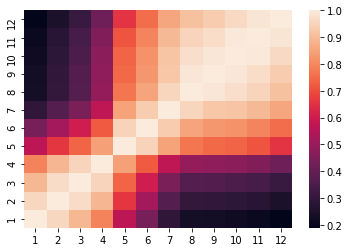

In [26]:
# Random
sns.heatmap(np.flip(lin_vals, 1), xticklabels=range(1, 12+1), yticklabels=range(12, 0, -1));

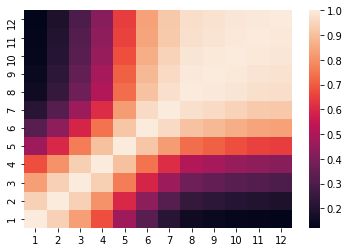

In [33]:
# Core set
sns.heatmap(np.flip(lin_vals, 1), xticklabels=range(1, 12+1), yticklabels=range(12, 0, -1));

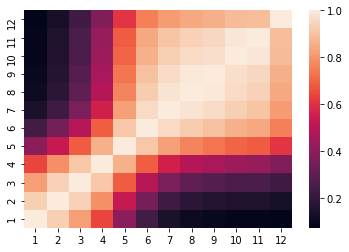

In [38]:
# Entropy
sns.heatmap(np.flip(lin_vals, 1), xticklabels=range(1, 12+1), yticklabels=range(12, 0, -1));

(200.0, 1000.0)

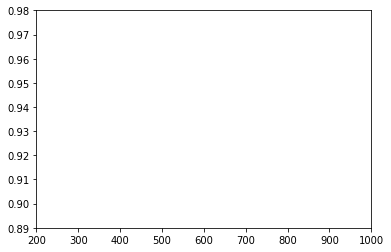

In [9]:
g = sns.lineplot(
    data=df_tr[df_tr.index.get_level_values("mode") == "long-besov"],
    x="labeled",
    y="f1_micro",
    hue="sampler",
    style="sampler",
    markers=True,
    dashes=False,
    ci=95,
    linewidth=3,
)
g.set_ylim(0.89, 0.98)
g.set_xlim(200, 1000)

In [7]:
g = sns.lineplot(
    data=df_tr[df_tr.index.get_level_values("mode") == "ada-besov"],
    x="labeled",
    y="f1_micro",
    hue="sampler",
    style="sampler",
    markers=True,
    dashes=False,
    ci=95,
    linewidth=3,
)
# g.set_ylim(0.82, 0.92)
# g.set_xlim(500, 1000)

ValueError: Could not interpret value `acuraccy` for parameter `y`

In [57]:
from transformers import AutoAdapterModel, AdapterConfig
from datasets import load_dataset

d = load_dataset("glue", "qqp")


# def save_dataset(hfd, name):
#     hfd["train"].to_pandas()[["question1", "question2", "label"]].sample(
#         5_000
#     ).reset_index(drop=True).to_csv(f"data/{name}/train.csv", header=False)
#     hfd["test"].to_pandas()[["question1", "question2", "label"]].sample(
#         2_000
#     ).reset_index(drop=True).to_csv(f"data/{name}/test.csv", header=False)
#     hfd["validation"].to_pandas()[["question1", "question2", "label"]].sample(
#         1_000
#     ).reset_index(drop=True).to_csv(f"data/{name}/validation.csv", header=False)


# save_dataset(d, "QQP")

In [8]:
model = AutoAdapterModel.from_pretrained("bert-base-uncased")
a = model.load_adapter("adapters/TREC-2-BERT-pfeiffer")
model.add_classification_head("head", num_labels=2)
model.add_adapter("head")
model.train_adapter("head")

In [37]:
from datasets import load_dataset
d = load_dataset("glue", "cola")

Reusing dataset glue (/home/jjukic/.cache/huggingface/datasets/glue/cola/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

In [65]:
filt = df_tr[df_tr.index.get_level_values("experiment") == 0]
filt

labeled  \
dataset model mode      sampler         experiment al_iter            
TREC-6  BERT  ada       entropy_dropout 0          0            100   
                                                   1            150   
                                                   2            200   
                                                   3            250   
                                                   4            300   
...                                                             ...   
              ada-besov random          0          14           800   
                                                   15           850   
                                                   16           900   
                                                   17           950   
                                                   18          1000   

                                                            train_loss  \
dataset model mode      sampler         experiment al_iter               
TREC-6  BERT  ada       entropy_dropout 0          0          0.001987   
                                                   1          0.041907   
                                                   2          0.002093   
                                                   3          0.010350   
                                                   4          0.003437   
...                                                                ...   
              ada-besov random          0          14         0.009267   
                                                   15         0.008287   
                                                   16         0.020721   
                                                   17         0.010288   
                                                   18         0.006573   

                                                            test_accuracy  \
dataset model mode      sampler         experiment al_iter                  
TREC-6  BERT  ada       entropy_dropout 0          0                0.864   
                                                   1                0.882   
                                                   2                0.880   
                                                   3                0.912   
                                                   4                0.920   
...                                                                   ...   
              ada-besov random          0          14               0.956   
                                                   15               0.964   
                                                   16               0.960   
                                                   17               0.964   
                                                   18               0.962   

                                                            f1_micro  \
dataset model mode      sampler         experiment al_iter             
TREC-6  BERT  ada       entropy_dropout 0          0           0.864   
                                                   1           0.882   
                                                   2           0.880   
                                                   3           0.912   
                                                   4           0.920   
...                                                              ...   
              ada-besov random          0          14          0.956   
                                                   15          0.964   
                                                   16          0.960   
                                                   17          0.964   
                                                   18          0.962   

                                                            f1_macro  \
dataset model mode      sampler         experiment al_iter             
TREC-6  BERT  ada       entropy_dropout 0          0        0.835029   
                  

In [66]:
grouped = filt.groupby(["dataset", "model", "mode", "sampler"]).agg(list)

In [67]:
grouped["subsample"] = grouped.selected.apply(lambda x: np.array(x[1:]).ravel())

In [68]:
grouped = grouped[grouped.index.get_level_values("mode") == "ada-besov"]
grouped

labeled  \
dataset model mode      sampler                                                              
TREC-6  BERT  ada-besov entropy_dropout  [100, 150, 200, 250, 300, 350, 400, 450, 500, ...   
                        random           [100, 150, 200, 250, 300, 350, 400, 450, 500, ...   

                                                                                train_loss  \
dataset model mode      sampler                                                              
TREC-6  BERT  ada-besov entropy_dropout  [0.030198002932593226, 0.0022930704755708574, ...   
                        random           [0.030198002932593226, 0.0031085699796676637, ...   

                                                                             test_accuracy  \
dataset model mode      sampler                                                              
TREC-6  BERT  ada-besov entropy_dropout  [0.884, 0.908, 0.916, 0.932, 0.934, 0.946, 0.9...   
                        random           [0.884, 0.91, 0.922, 0.928, 0.932, 0.938, 0.94...   

                                                                                  f1_micro  \
dataset model mode      sampler                                                              
TREC-6  BERT  ada-besov entropy_dropout  [0.884, 0.908, 0.916, 0.932, 0.934, 0.946, 0.9...   
                        random           [0.884, 0.91, 0.922, 0.928, 0.932, 0.938, 0.94...   

                                                                                  f1_macro  \
dataset model mode      sampler                                                              
TREC-6  BERT  ada-besov entropy_dropout  [0.8522451902549254, 0.8846766609591658, 0.895...   
                        random           [0.8522451902549254, 0.870231832981446, 0.8885...   

                                                                                  selected  \
dataset model mode      sampler                                                              
TREC-6  BERT  ada-besov entropy_dropout  [[3978, 2889, 1235, 2943, 2625, 1571, 2305, 11...   
                        random           [[3978, 2889, 1235, 2943, 2625, 1571, 2305, 11...   

                                                                                 subsample  
dataset model mode      sampler                                                             
TREC-6  BERT  ada-besov entropy_dropout  [4022, 3891, 1695, 3820, 1854, 579, 450, 3724,...  
                        random           [2351, 220, 3058, 3157, 3413, 2137, 1133, 2961...

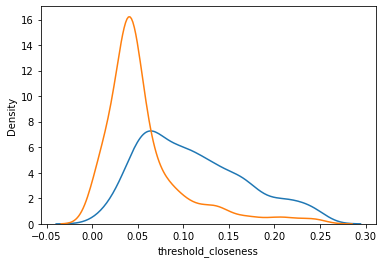

In [89]:
for index, row in grouped.iterrows():
    sampler = index[3]
    indices = row["subsample"]
    df_sampler = df.loc[indices]
    g = sns.kdeplot(data=df_sampler, x="threshold_closeness")
#     g.set(xlim=(-0.5, 5))

In [56]:
df = pd.read_csv("stats/BERT-TREC-6-unipelt.csv", index_col=0)

In [58]:
df.corr()

,correctness,confidence,variability,forgetfulness,threshold_closeness,pvi
correctness,1.000000,0.939003,-0.738779,-0.347553,-0.803715,0.121503
confidence,0.939003,1.000000,-0.764431,-0.343353,-0.891419,0.157457
variability,-0.738779,-0.764431,1.000000,-0.030097,0.897644,-0.075127
forgetfulness,-0.347553,-0.343353,-0.030097,1.000000,-0.003712,-0.106747
threshold_closeness,-0.803715,-0.891419,0.897644,-0.003712,1.000000,-0.123080
pvi,0.121503,0.157457,-0.075127,-0.106747,-0.123080,1.000000
